<a href="https://colab.research.google.com/github/jjyjung/ai/blob/gh-pages/tf_keras_CNN_CUB200.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')   # google drive를 google colab에 연결. 처음 실행 시, 인증 필요

Mounted at /content/gdrive


In [2]:
# 먼저 구글 드라이브의 적절한 위치에 CUB200.zip을 복사해둡니다.
# 아래는 CUB200.zip을 구글 드라이브의 원하는 위치에 압축해제하는 코드입니다.
# 한 번 실행한 후에는 재실행을 방지하기 위하여 #로 주석처리해두기 바랍니다.
# !unzip '/content/gdrive/My Drive/Colab Notebooks/ai/CNN/CUB200.zip' -d '/content/gdrive/My Drive/Colab Notebooks/ai/CNN/CUB200'

## CUB200-2011 데이터셋

CalTech에서 구축한 새 품종 분류 데이터셋 (새 200종의 이미지 11788장)

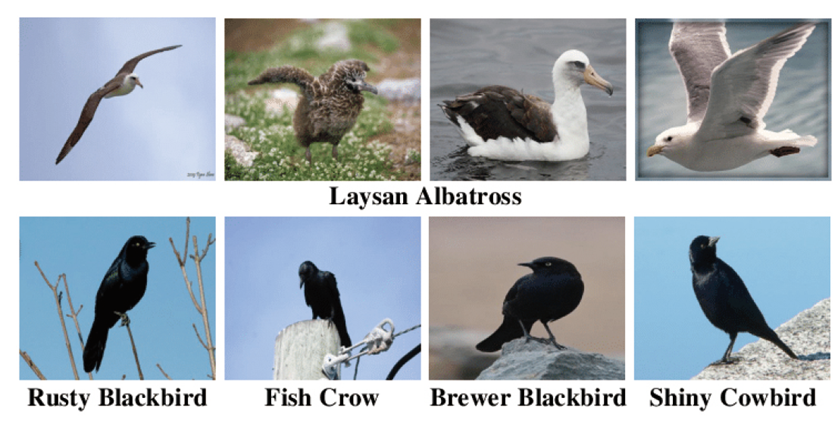

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten,Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet50 import ResNet50,preprocess_input
from tensorflow.keras.preprocessing import image
import os

dir = "/content/gdrive/My Drive/Colab Notebooks/ai/CNN/"
train_folder = dir + 'CUB200/train'
test_folder = dir + 'CUB200/test'

class_reduce=0.1 # 클래스 수를 10%(20개)로 줄여서 데이터양 줄임(테스트용 속도를 위해)
num_class=int(len(os.listdir(train_folder))*class_reduce) # 클래스 개수

In [5]:
x_train,y_train=[],[]
for i,class_name in enumerate(os.listdir(train_folder)):
  if i < num_class: # 14~15행에서 지정된 클래스만 사용
    for fname in os.listdir(train_folder+'/'+class_name):
      img=image.load_img(train_folder+'/'+class_name+'/'+fname,target_size=(224,224))
      if len(img.getbands())!=3:
        print("주의: 유효하지 않은 영상 발생",class_name,fname)
        continue
      x=image.img_to_array(img)
      x=preprocess_input(x)
      x_train.append(x)
      y_train.append(i)

x_test,y_test=[],[]
for i,class_name in enumerate(os.listdir(test_folder)):
  if i < num_class: # 14~15행에서 지정된 클래스만 사용
    for fname in os.listdir(test_folder+'/'+class_name):
      img=image.load_img(test_folder+'/'+class_name+'/'+fname,target_size=(224,224))
      if len(img.getbands())!=3:
        print("주의: 유효하지 않은 영상 발생",class_name,fname)
        continue
      x=image.img_to_array(img)
      x=preprocess_input(x)
      x_test.append(x)
      y_test.append(i)

x_train=np.asarray(x_train)
y_train=np.asarray(y_train)
x_test=np.asarray(x_test)
y_test=np.asarray(y_test)
y_train=tf.keras.utils.to_categorical(y_train,num_class)
y_test=tf.keras.utils.to_categorical(y_test,num_class)

In [6]:
for i,class_name in enumerate(os.listdir(test_folder)):
  if i < num_class: # 13~14행이 지정한 부류만 사용
    print(class_name, "\t파일개수:", len(os.listdir(test_folder+'/'+class_name)))

001.Black_footed_Albatross 	파일개수: 30
002.Laysan_Albatross 	파일개수: 30
003.Sooty_Albatross 	파일개수: 28
004.Groove_billed_Ani 	파일개수: 30
005.Crested_Auklet 	파일개수: 14
006.Least_Auklet 	파일개수: 11
007.Parakeet_Auklet 	파일개수: 23
008.Rhinoceros_Auklet 	파일개수: 18
009.Brewer_Blackbird 	파일개수: 29
010.Red_winged_Blackbird 	파일개수: 30
011.Rusty_Blackbird 	파일개수: 30
012.Yellow_headed_Blackbird 	파일개수: 26
013.Bobolink 	파일개수: 30
014.Indigo_Bunting 	파일개수: 30
015.Lazuli_Bunting 	파일개수: 28
016.Painted_Bunting 	파일개수: 28
017.Cardinal 	파일개수: 27
018.Spotted_Catbird 	파일개수: 15
019.Gray_Catbird 	파일개수: 29
020.Yellow_breasted_Chat 	파일개수: 29


## 전이학습 (Transfer Learning)
ImageNet으로 사전학습된 ResNet50 모델을 사용

In [7]:
# Transfer Learning 부분
base_model=ResNet50(weights='imagenet',
                    include_top=False,        # FC층 및 출력층을 제외시키고 Conv층만 가져오는 옵션
                    input_shape=(224,224,3))  #
base_model.trainable=False   # 컨볼루션층의 가중치를 freezing 시키고 싶을 때 사용
cnn=Sequential()
cnn.add(base_model)
cnn.add(Flatten())
cnn.add(Dense(1024,activation='relu'))
cnn.add(Dense(num_class,activation='softmax'))

94765736/94765736 [==============================] - 0s 0us/step


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 1024)              102761472 
                                                                 
 dense_1 (Dense)             (None, 20)                20500     
                                                                 
Total params: 126369684 (482.06 MB)
Trainable params: 102781972 (392.08 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


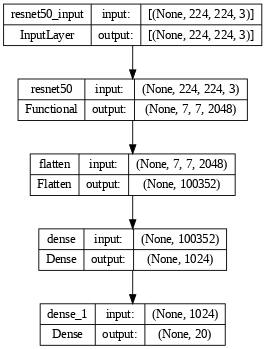

In [11]:
# 모델 확인
cnn.summary()

# SVG로 그리기
from IPython.display import SVG
from tensorflow.keras.utils import plot_model, model_to_dot
%matplotlib inline
SVG(model_to_dot(cnn, show_shapes=True, dpi=65).create(prog='dot', format='svg'))  # SVG로 가시화
plot_model(cnn, to_file=dir+'cnn_model.png', show_shapes=True, show_layer_names=True, dpi=65) # 파일 출력

## ResNet50 Architecture
2015년 ILSVRC에서 5순위 정확도에서 3.5%로 우승한 Microsoft의 개발 모형

residual learning을 적용하여 간단한 학습 형태로 전이학습에 널리 사용되고 있음

#### Residual learning (잔차학습) 또는 skip connection
기울기 소실을 막기 위하여 컨볼루션층과 병렬로 원본 데이터를 더해주는 설계 기법

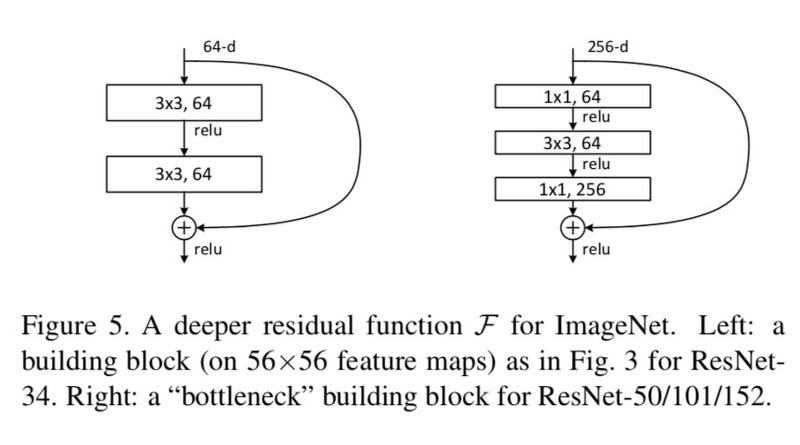

#### ResNet50의 구조
총 50개의 학습 계층을 포함

1 conv => 1개

Stage 1 : 3 conv * 3 block => 9개

Stage 2 : 3 conv * 4 block => 12개

Stage 3 : 3 conv * 6 block => 18개

Stage 4 : 3 conv * 3 block => 9개

1 FC => 1개

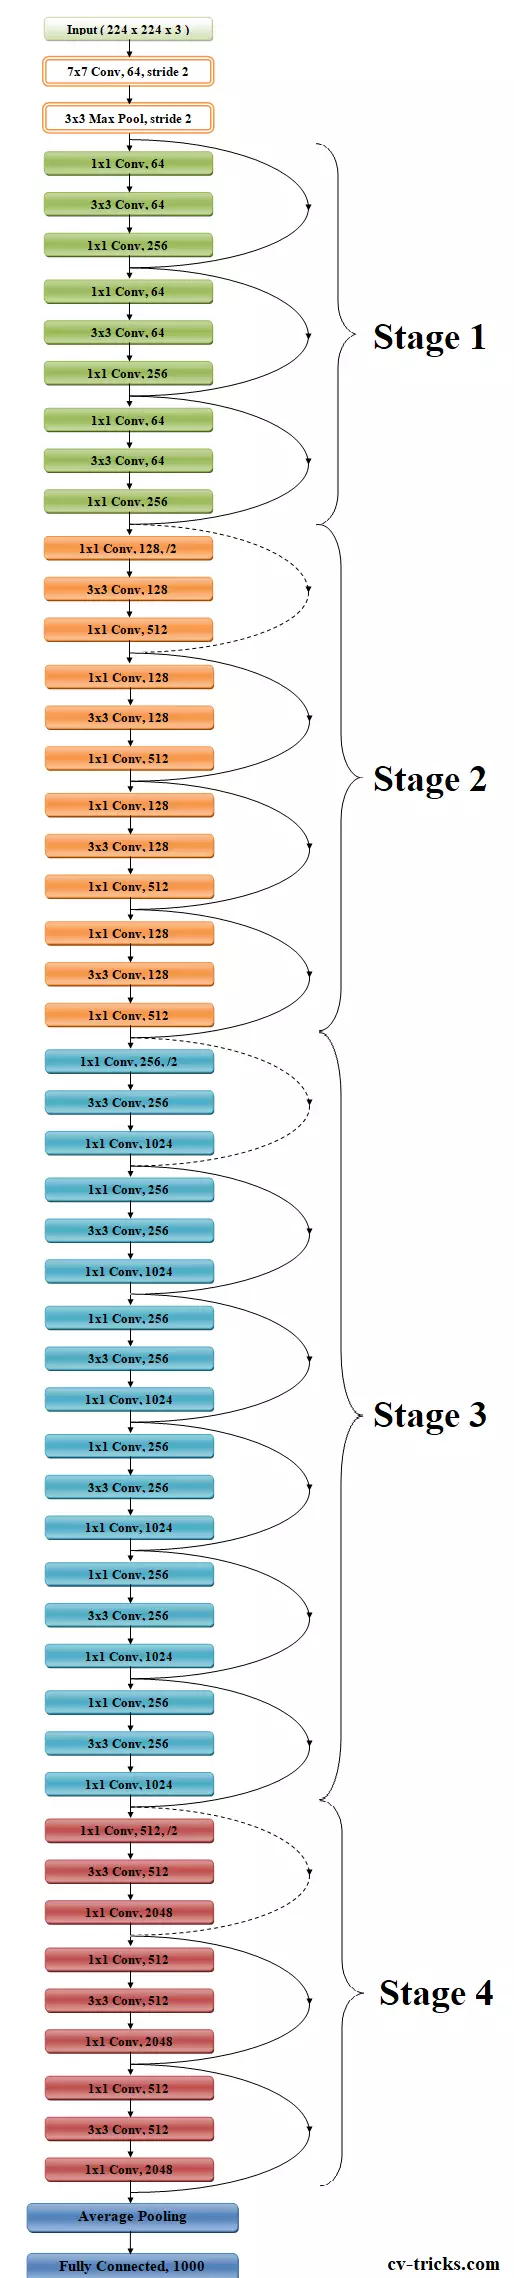

#### Global Average Pooling (GAP)
ResNet은 FC의 parameter를 줄이기 위하여 Global Average Pooling을 사용함

각 Feature map의 평균값을 단일 노드로 매핑하는 방법

https://alexisbcook.github.io/2017/global-average-pooling-layers-for-object-localization/

https://github.com/keras-team/keras/issues/7920

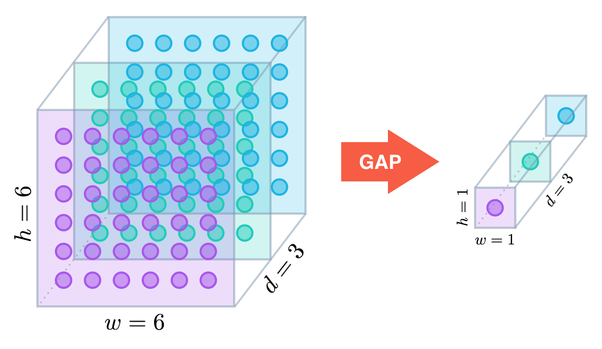

#### Batch Normalization (BN)

배치별로 평균과 분산을 이용해 정규화하여 layer를 규제(regularization)하는 기법

정규화한 후, Scale 및 Shift 파라미터는 학습시킴

Dropout보다 성능이 우수함 (Dropout 대체하여 사용)

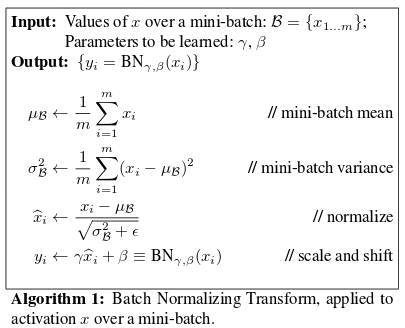

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

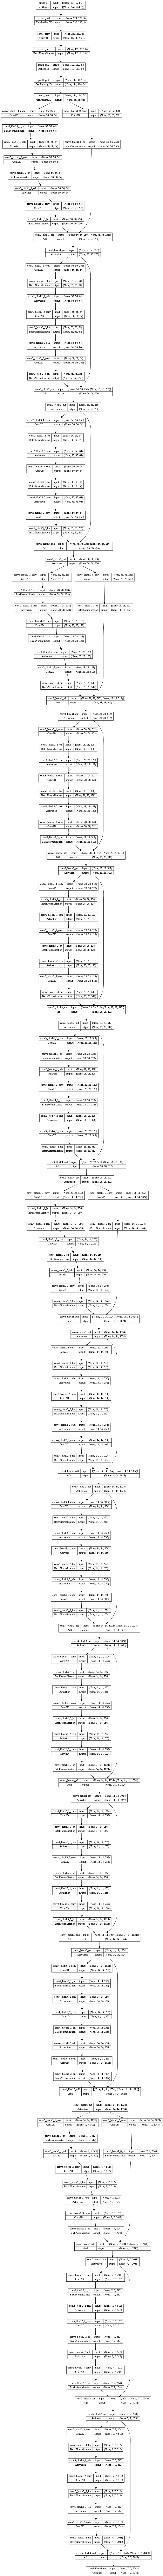

In [13]:
# ResNet50 모델 확인
# base_model=ResNet50(weights='imagenet',include_top=False,input_shape=(224,224,3))
base_model.summary()

# SVG로 그리기
from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot, plot_model
%matplotlib inline
SVG(model_to_dot(base_model, show_shapes=True, dpi=65).create(prog='dot', format='svg'))  # SVG로 가시화
plot_model(base_model, to_file=dir+'cnn_resnet.png', show_shapes=True, show_layer_names=True, dpi=65) # 파일 출력

In [14]:
import matplotlib.pyplot as plt

def draw_plot(hist):
  # 정확률 그래프
  plt.plot(hist.history['accuracy'])
  plt.plot(hist.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend(['Train','Validation'],loc='best')
  plt.grid()
  plt.show()

  # 손실 함수 그래프
  plt.plot(hist.history['loss'])
  plt.plot(hist.history['val_loss'])
  plt.title('Model loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend(['Train','Validation'],loc='best')
  plt.grid()
  plt.show()

#### Freezing 시킨 Transfer Learning (전이학습) 결과
컨볼루션 층의 가중치는 고정시킨 채, FC층만 학습시킴

Epoch 1/100
50/50 [==============================] - 19s 152ms/step - loss: 2.3049 - accuracy: 0.4850 - val_loss: 1.3302 - val_accuracy: 0.6621
Epoch 2/100
50/50 [==============================] - 5s 102ms/step - loss: 0.0766 - accuracy: 0.9783 - val_loss: 1.2673 - val_accuracy: 0.7029
Epoch 3/100
50/50 [==============================] - 6s 120ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 1.0790 - val_accuracy: 0.7243
Epoch 4/100
50/50 [==============================] - 6s 118ms/step - loss: 6.6974e-04 - accuracy: 1.0000 - val_loss: 1.0650 - val_accuracy: 0.7262
Epoch 5/100
50/50 [==============================] - 6s 119ms/step - loss: 5.2286e-04 - accuracy: 1.0000 - val_loss: 1.0576 - val_accuracy: 0.7301
Epoch 6/100
50/50 [==============================] - 5s 106ms/step - loss: 4.2559e-04 - accuracy: 1.0000 - val_loss: 1.0513 - val_accuracy: 0.7301
Epoch 7/100
50/50 [==============================] - 5s 103ms/step - loss: 3.6347e-04 - accuracy: 1.0000 - val_loss: 1.0465 - val

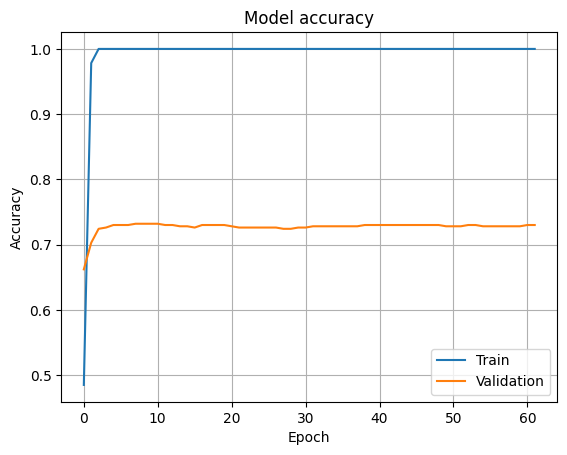

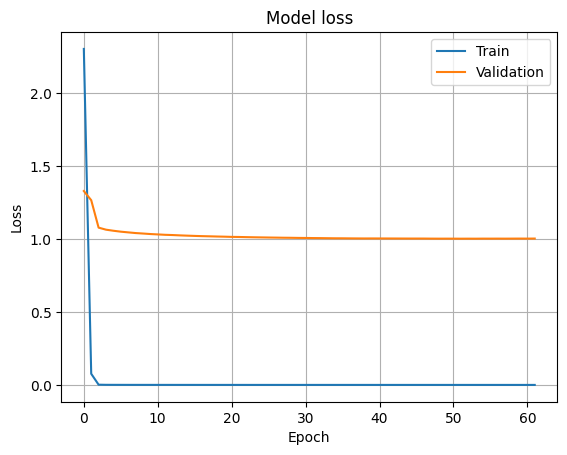

In [15]:
# 위에서 설계한 cnn 구조
# base_model=ResNet50(weights='imagenet',include_top=False,input_shape=(224,224,3))
# base_model.trainable=False   # 컨볼루션층의 가중치를 freezing 시키고 싶을 때 사용
# cnn=Sequential()
# cnn.add(base_model)
# cnn.add(Flatten())
# cnn.add(Dense(1024,activation='relu'))
# cnn.add(Dense(num_class,activation='softmax'))

from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor = 'val_loss', patience = 10, mode='min')

cnn.compile(loss='categorical_crossentropy',optimizer=Adam(0.00002),metrics=['accuracy']) # Fine-tuning을 위하여 학습률을 0.0002로 매우 낮게 설정함
hist=cnn.fit(x_train,y_train,batch_size=12,epochs=100,validation_data=(x_test,y_test),
             callbacks=[early_stop],shuffle = True,verbose=1)

res=cnn.evaluate(x_test,y_test,verbose=0)
print("정확률(%):",res[1]*100)
draw_plot(hist)

In [16]:
# 테스트 집합
res = cnn.predict(x_test)

# Confusion Matrix
conf=np.zeros((20,20))
for i in range(len(res)):
  conf[res[i].argmax()][y_test[i].argmax()]+=1
print(conf)

# 정확도 계산
no_correct=0
for i in range(20):
  no_correct+=conf[i][i]
accuracy=no_correct/len(res)
print("정확도(%):",accuracy*100)

17/17 [==============================] - 3s 100ms/step
[[25.  4.  9.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 2. 21.  3.  0.  0.  1.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 2.  5. 15.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0. 23.  0.  0.  0.  0.  3.  0.  4.  0.  1.  0.  0.  0.  0.  1.
   0.  0.]
 [ 0.  0.  1.  0. 13.  0.  2.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0.  0.  0.  9.  2.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0.  0.  1.  1. 17.  0.  0.  0.  1.  0.  1.  0.  0.  0.  0.  0.
   0.  0.]
 [ 1.  0.  0.  0.  0.  0.  2. 14.  1.  0.  1.  0.  0.  0.  0.  0.  0.  0.
   0.  1.]
 [ 0.  0.  0.  1.  0.  0.  0.  0. 10.  2.  6.  0.  0.  0.  0.  0.  0.  0.
   1.  0.]
 [ 0.  0.  0.  2.  0.  0.  0.  1.  1. 22.  0.  1.  3.  1.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  4.  0. 16.  0.  0.  0.  0.  0.  0.  0.
   3.  0.]
 [ 0.  0. 

#### Fine-tuning 시키는 Transfer Learning (전이학습) 결과

FC층 뿐만 아니라, 컨볼루션 층까지 미세하게 학습시킴

Epoch 1/100
50/50 [==============================] - 44s 235ms/step - loss: 2.8495 - accuracy: 0.3467 - val_loss: 1.2166 - val_accuracy: 0.6660
Epoch 2/100
50/50 [==============================] - 10s 207ms/step - loss: 0.0551 - accuracy: 0.9783 - val_loss: 1.0171 - val_accuracy: 0.7107
Epoch 3/100
50/50 [==============================] - 11s 218ms/step - loss: 0.0101 - accuracy: 0.9950 - val_loss: 1.0041 - val_accuracy: 0.7107
Epoch 4/100
50/50 [==============================] - 11s 219ms/step - loss: 0.0043 - accuracy: 1.0000 - val_loss: 1.0449 - val_accuracy: 0.7184
Epoch 5/100
50/50 [==============================] - 10s 204ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 1.0721 - val_accuracy: 0.7049
Epoch 6/100
50/50 [==============================] - 11s 215ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 1.0795 - val_accuracy: 0.7107
Epoch 7/100
50/50 [==============================] - 11s 215ms/step - loss: 8.9969e-04 - accuracy: 1.0000 - val_loss: 1.0753 - val_accur

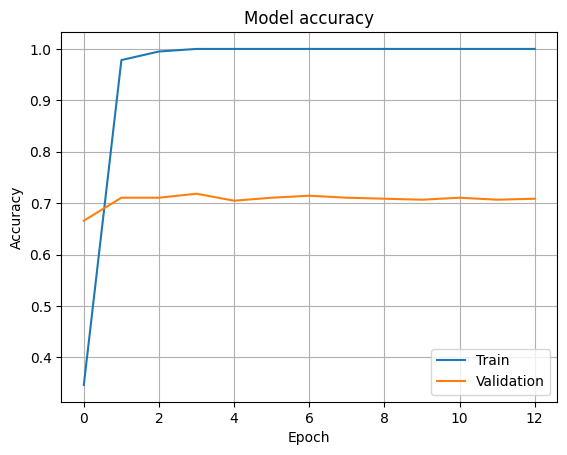

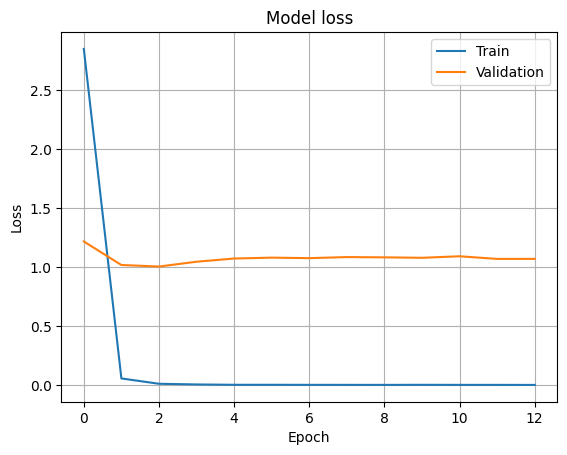

In [18]:
# 위에서 설계한 cnn 구조
base_model2=ResNet50(weights='imagenet',include_top=False,input_shape=(224,224,3))
# base_model2.trainable=False   # 컨볼루션층의 가중치를 freezing 시키고 싶을 때 사용
cnn2=Sequential()
cnn2.add(base_model2)
cnn2.add(Flatten())
cnn2.add(Dense(1024,activation='relu'))
cnn2.add(Dense(num_class,activation='softmax'))

from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor = 'val_loss', patience = 10, mode='min')

cnn2.compile(loss='categorical_crossentropy',optimizer=Adam(0.00002),metrics=['accuracy'])
hist=cnn2.fit(x_train,y_train,batch_size=12,epochs=100,validation_data=(x_test,y_test),
             callbacks=[early_stop],shuffle = True,verbose=1)

res=cnn2.evaluate(x_test,y_test,verbose=0)
print("정확률(%):",res[1]*100)
draw_plot(hist)

In [19]:
# 테스트 집합
res = cnn2.predict(x_test)

# Confusion Matrix
conf=np.zeros((20,20))
for i in range(len(res)):
  conf[res[i].argmax()][y_test[i].argmax()]+=1
print(conf)

# 정확도 계산
no_correct=0
for i in range(20):
  no_correct+=conf[i][i]
accuracy=no_correct/len(res)
print("정확도(%):",accuracy*100)

17/17 [==============================] - 3s 104ms/step
[[21.  2.  5.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 2. 23.  5.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 2.  5. 16.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0. 30.  0.  0.  0.  0.  4.  1.  6.  1.  3.  0.  0.  0.  0.  0.
   2.  0.]
 [ 0.  0.  0.  0. 12.  0.  2.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0.  0.  0.  7.  0.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   1.  0.]
 [ 0.  0.  1.  0.  1.  4. 18.  0.  2.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 5.  0.  0.  0.  1.  0.  1. 15.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  9.  4.  3.  0.  1.  0.  0.  0.  0.  0.
   2.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0. 19.  0.  0.  2.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  6.  0.  9.  0.  0.  0.  0.  0.  0.  0.
   2.  1.]
 [ 0.  0. 